In [1]:
import sys # for automation and parallelisation
manual, scenario = (True, 'base') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])
if manual:
    %matplotlib inline


Bad key text.latex.preview in file C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\

In [2]:
import numpy as np
import pandas as pd
from quetzal.model import stepmodel
from quetzal.io import excel

# Inner-zonal assignment
## Saves transport demand within zones
## Needs inner-zonal volumes and trip lengths by mode

In [3]:
input_path = '../input/transport_demand/'
output_path = '../output/'
model_path = '../model/' + scenario + '/'

In [4]:
# Load scenario parameters
params = excel.read_var(file='../input/parameters.xls', scenario=scenario)

## Load transport demand data from VP2030

The German federal government's transport study "[Bundesverkehrswegeplan 2030](https://www.bmvi.de/SharedDocs/DE/Artikel/G/BVWP/bundesverkehrswegeplan-2030-inhalte-herunterladen.html)" uses origin destination matrices on NUTS3-level resolution and makes them accessible under copyright restrictions for the base year and the year of prognosis. These matrices cannot be published in their original form.

In [6]:
vp2010 = pd.read_csv(input_path + 'PVMatrix_BVWP15_A2010.csv', sep=';', encoding='latin-1')
vp2030 = pd.read_csv(input_path + 'PVMatrix_BVWP15_P2030.csv', sep=';', encoding='latin-1')

In [7]:
print(vp2010.shape)
vp2010[vp2010.isna().any(axis=1)]

(313590, 38)


,# Quelle,Ziel,Bahn_Fz1,Bahn_Fz2,Bahn_Fz3,Bahn_Fz4,Bahn_Fz5,Bahn_Fz6,MIV_Fz1,MIV_Fz2,...,Rad_Fz3,Rad_Fz4,Rad_Fz5,Rad_Fz6,Fuß_Fz1,Fuß_Fz2,Fuß_Fz3,Fuß_Fz4,Fuß_Fz5,Fuß_Fz6


In [8]:
for df in [vp2010, vp2030]:
    df.rename(columns={'# Quelle': 'origin', 'Ziel': 'destination'}, inplace=True)

### Cast to 2017 data

In [9]:
def get_vp2017(vp2010_i, vp2030_i):
    return vp2010_i + (vp2030_i - vp2010_i) * (7/20)

In [10]:
# Calculate a OD table for the year 2017
vp2017 = get_vp2017(vp2010.set_index(['origin', 'destination']),
                    vp2030.set_index(['origin', 'destination']))

In [11]:
vp2017.dropna(how='all', inplace=True)
vp2017 = vp2017[list(vp2017.columns)].astype(int)
#vp2017.head()

In [15]:
# Keep only inner-cell transport demand
vp2017.reset_index(inplace=True)
vp2017 = vp2017.loc[vp2017['origin']==vp2017['destination']]
#vp2017.drop('destination', axis=1, inplace=True)
len(vp2017)

412

### Update zone codes and map to NUTS

In [16]:
# NUTS3-level zones changed after the VP2030
# Thus the VP table needs to be updated manually
update_dict = {3156: 3159, 3152: 3159, # Göttingen
               13001: 13075, 13002: 13071, 13005: 13073, 13006: 13074,
               13051: 13072, 13052: 13071, 13053: 13072, 13054: 13076, 13055: 13071, 13056: 13071,
               13057: 13073, 13058: 13074, 13059: 13075, 13060: 13076, 13061: 13073, 13062: 13075,
               16056: 16063}

In [17]:
# What is the sum of all trips? For Validation
cols = [c for c in vp2017.columns if c not in ['origin', 'destination']]
orig_sum = vp2017[cols].sum().sum()
orig_sum

85242846874

In [18]:
# Update LAU codes
vp2017['origin'] = vp2017['origin'].replace(update_dict)
vp2017['destination'] = vp2017['destination'].replace(update_dict)

In [19]:
# Replace LAU with NUTS
sm = stepmodel.read_json(model_path + 'de_zones')
if not 'lau_id' in sm.zones.columns:
    sm.zones['lau_id'] = sm.zones['ARS'].apply(lambda l: l[0]).apply(str).str[:-4]
lau_dict = sm.zones.set_index('lau_id')['NUTS_ID'].to_dict()
vp2017['origin'] = vp2017['origin'].astype(str).map(lau_dict)
vp2017['destination'] = vp2017['destination'].astype(str).map(lau_dict)
# Restrict to cells in the model
vp2017 = vp2017[~vp2017.isna().any(axis=1)]
vp2017.shape

(412, 38)

In [20]:
# What is the sum after zone translation?
vp2017[cols].sum().sum() / orig_sum

1.0

In [21]:
# Aggregate origins
vp2017 = vp2017.groupby(['origin', 'destination']).sum().reset_index()
vp2017[cols].sum().sum() / orig_sum

1.0

### Re-arrange the modes and purposes

In [22]:
# Merge bicycle and foot
for p in range(1,7):
    vp2017['walk_Fz' + str(p)] = vp2017['Rad_Fz' + str(p)] + vp2017['Fuß_Fz' + str(p)]
vp2017 = vp2017[[col for col in list(vp2017.columns) if not col[:3] in ['Rad', 'Fuß']]]

In [27]:
# Make columns two levels
vp2017.set_index(['origin', 'destination'], inplace=True)
mode_dict = {'OESPV': 'bus', 'Bahn': 'rail', 'MIV': 'car', 'Luft': 'air', 'walk': 'walk'}
vp2017.columns = pd.MultiIndex.from_tuples(
    [(col.split('_')[1], mode_dict[col.split('_')[0]]) for col in vp2017.columns],
    names=['segment', 'mode'])

In [28]:
# Merge purpose 5 and 6 due to calibration data limitations
vp2017['Fz6'] = vp2017['Fz5'] + vp2017['Fz6']
vp2017.drop('Fz5', axis=1, inplace=True)

In [30]:
# Ditch air columns
vp2017.drop('air', axis=1, level=1, inplace=True)

array([<AxesSubplot:ylabel='Fz1'>, <AxesSubplot:ylabel='Fz2'>,
       <AxesSubplot:ylabel='Fz3'>, <AxesSubplot:ylabel='Fz4'>,
       <AxesSubplot:ylabel='Fz6'>], dtype=object)

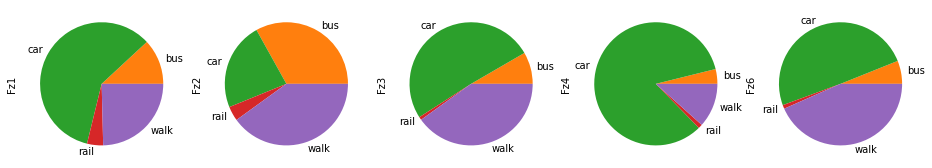

In [29]:
# Modal split by trips
vp2017.T.sum(axis=1).unstack('segment').plot.pie(
    subplots=True, figsize=(16, 4), legend=False)

In [31]:
# Clear the RAM
vp2010 = None
vp2030 = None

In [32]:
volumes = vp2017

### Split into model zones

Use population shares of the NUTS3 sub-zone

In [38]:
vol = sm.zones[['FID', 'pop_share']].merge(sm.zones[['FID', 'pop_share']], how='cross'
                                          ).rename(columns={'FID_x':'origin', 'FID_y':'destination'})
island_dict = sm.zones.loc[['outer_1', 'outer_2'], 'NUTS_ID'].to_dict()
vol['o'] = vol['origin'].replace(island_dict).str[:5]
vol['d'] = vol['destination'].replace(island_dict).str[:5]
vol = vol.loc[vol['o']==vol['d']]
segments = [c for c in volumes.columns if c not in ['origin', 'destination']]
for seg in segments:
    segment = volumes[seg].to_dict()
    vol[seg] = vol['pop_share_x'] * vol['pop_share_y'] * [
        segment[tuple(od)] 
        if tuple(od) in segment.keys() else np.nan
        for od in vol[['o', 'd']].values]

In [59]:
# Somehow, DEG0N was overwritten
vol = vol.loc[~vol[segments].isna().any(axis=1)]

In [60]:
# Filter new inner-zonal trips
volumes = vol.loc[vol['origin']==vol['destination'], segments+['origin']].set_index('origin')
volumes.shape

(2224, 20)

In [68]:
volumes.columns = pd.MultiIndex.from_tuples(list(volumes.columns),
                                            names=['segment', 'mode'])

## Load MiD2017 data for trip lengths

Generate average trip lengths using survey data.

In [92]:
trips = pd.read_csv(input_path + 'MiD2017_Regional_Wege.csv', sep=';')
trips = trips[['KKZ_SO', 'KKZ_ZO', 'VBGEM_SO', 'VBGEM_ZO', 'SKTYP', 'wegkm_imp', 'km_routing_gr',
               'wegmin_imp1', 'hwzweck1', 'hvm_diff2', 'vm_kombi', 'anzpers',
               'auto', 'P_FKARTE', 'multimodal', 'bahn28', 'bus28', 'bahn28_zo',
               'bus28_zo', 'W_DETAIL', 'W_SO2']]
trips.columns = ['o', 'd', 'origin', 'destination', 'SKTYP', 'distance', 'distance_routed',
                 'duration', 'purpose', 'mode', 'mode_combo', 'n_persons',
                 'car_avail', 'ticket_type', 'mode_affinity', 'dist_train_origin',
                 'dist_bus_origin', 'dist_train_destination', 'dist_bus_destination',
                 'W_DETAIL', 'W_SO2']

In [93]:
trips['distance'] = pd.to_numeric(trips['distance'].str.replace(',', '.'))

In [94]:
# Filter for inner-German trips
trips = trips.loc[(trips['W_SO2']!=2) & (trips['W_SO2']!=3)]
len(trips)

959778

In [95]:
# Filter unspecified rows
trips = trips.loc[(trips['purpose']!=99) &
                  (trips['o']<9999) &
                  (trips['d']<9999) &
                  (trips['mode']<24) &
                  (trips['distance_routed']!=708) &
                  ~(trips['origin'].isin([7000000701, 999999995])) &
                  ~(trips['destination'].isin([7000000701, 999999995]))]
len(trips)

374353

In [96]:
# Filter for inner-zonal traffic (NUTS3 level)
trips = trips.loc[trips['origin']==trips['destination']]
len(trips)

225910

In [104]:
# Number of Gemeindeverbände in survey
len(trips[['origin', 'destination']].stack().unique())

2387

In [106]:
# Remove ferries and air
trips = trips.loc[trips['mode']!=19]
trips = trips.loc[trips['mode']!=23]
len(trips)

225859

In [107]:
# Align regional specifics with urbanisation degree
mid_urbanisation_dict = {1:1, 2:2, 3:3, 4:3}
trips['urbanisation'] = trips['SKTYP'].map(mid_urbanisation_dict)

In [109]:
trips.groupby('urbanisation')['origin'].count()

urbanisation
1    86359
2    84439
3    55061
Name: origin, dtype: int64

In [110]:
# Make unknown number of persons equal to one
trips.loc[trips['n_persons']>6] = 1

In [111]:
# Match trip purpose with VP2030 categories
# Note: Holiday trips are included in private (6)
purpose_mid_vp_dict = {1: 'Fz1', 2: 'Fz4', 3: 'Fz2', 4: 'Fz3',
                       5: 'Fz3', 6: 'Fz6', 7: 'Fz6', 99: 'Fz6'}
trips['purpose_vp'] = trips['purpose'].map(purpose_mid_vp_dict)

In [112]:
# Match mode with the model modes
# Non-motorised modes, buses, and rail are merged
mode_mid_vp_dict = {1:'walk', 2:'walk', 3:'walk', 4:'car',
                    5:'car', 6:'car', 7:'car', 8:'car', 9:'car',
                    10:'car', 11:'car', 12:'bus', 13:'bus',
                    14:'bus', 15:'bus', 16:'rail', 17:'car',
                    18:'car', 19:'walk', 20:'rail', 21:'bus',
                    22:'bus', 23:'air', 24:'walk'}
trips['mode_model'] = trips['mode'].map(mode_mid_vp_dict)

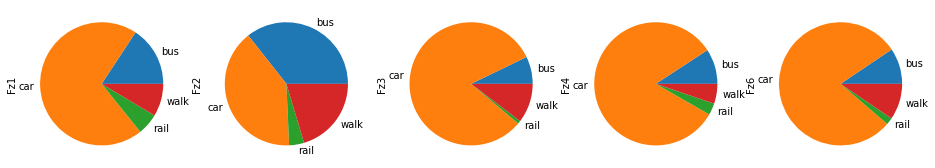

In [113]:
# Modal split by number of trips
axs = trips.groupby(['mode_model','purpose_vp']).size().unstack(fill_value=0).plot.pie(
    subplots=True, figsize=(16, 4), legend=False)

array([<AxesSubplot:ylabel='Fz1'>, <AxesSubplot:ylabel='Fz2'>,
       <AxesSubplot:ylabel='Fz3'>, <AxesSubplot:ylabel='Fz4'>,
       <AxesSubplot:ylabel='Fz6'>], dtype=object)

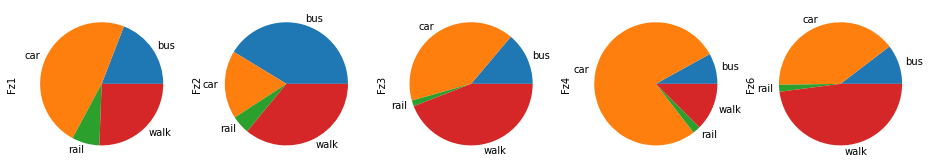

In [114]:
# Compared to VP2030
volumes.T.sum(axis=1).unstack('segment').plot.pie(
    subplots=True, figsize=(16, 4), legend=False)

### Generate averages

In [115]:
# Count the number of observations to grasp statistical validity
trips.groupby(['urbanisation', 'mode_model', 'purpose_vp'])['origin'].count().unstack('purpose_vp')

purpose_vp                Fz1   Fz2    Fz3   Fz4    Fz6
urbanisation mode_model                                
1            bus         4001  2050   5431   472   6019
             car         7832  1653  22724  2074  21368
             rail        1334   301    635   147   1134
             walk        1730   853   3845   185   3175
2            bus          580  1581   1063   101   1121
             car         7337  2087  33176  2078  25396
             rail         276   168     87    35    233
             walk         532  1237   4037    98   2846
3            bus          134  1111    384    49    398
             car         5833  1591  22350  1415  16680
             rail          73    53     37    25     82
             walk         313   619   2033    69   1578

In [116]:
trips.groupby(['urbanisation', 'mode_model', 'purpose_vp'])['distance'].mean().unstack('purpose_vp')

purpose_vp                     Fz1        Fz2        Fz3        Fz4        Fz6
urbanisation mode_model                                                       
1            bus          7.516821   5.857600   5.102178   6.758665   5.962693
             car         10.169157   5.765124   5.088603   8.496427   6.616233
             rail        16.827886  14.258904  11.165213  37.152041  19.444242
             walk         1.902925   1.828746   1.376791   2.795892   2.156334
2            bus          8.333517   5.976875   5.007093   5.760198   5.837270
             car          9.348379   3.978845   4.086749   8.328965   5.565192
             rail        28.324891  14.342976  13.336782  32.516857  38.703820
             walk         2.511147   1.493411   1.317151   1.706531   1.963633
3            bus         10.681194   6.028443   5.510859  10.562245   6.637714
             car          8.463729   4.397128   3.829391   9.507435   5.394392
             rail        54.291918  24.302453  38.332162  40.219200  58.385488
             walk         2.191470   1.454653   1.263851   1.954203   1.873162

In [117]:
# Generate average lengths and times
len_dict = trips.groupby(['urbanisation', 'mode_model', 'purpose_vp'])['distance'].mean().to_dict()
time_dict = trips.groupby(['urbanisation', 'mode_model', 'purpose_vp'])['duration'].mean().to_dict()

In [118]:
# Generate average occupation factors for car trips
# Necessary to calculate vehicle kilometers
car_occ_dict = trips.loc[trips['mode_model']=='car'].groupby(
    ['urbanisation', 'purpose_vp'])['n_persons'].mean().to_dict()
trips.loc[trips['mode_model']=='car'].groupby(
    ['urbanisation', 'purpose_vp'])['n_persons'].mean().unstack('purpose_vp')

purpose_vp,Fz1,Fz2,Fz3,Fz4,Fz6
urbanisation,,,,,
1,1.165220,2.416818,1.568738,1.265188,2.100571
2,1.159602,2.407283,1.467687,1.296920,2.002363
3,1.181553,2.509114,1.468143,1.299647,2.000600


### Generate prices

See cal11 for values and explanation

In [119]:
trips['price'] = 0

In [123]:
# Car
vc_car = params['car_var_cost']
fix_car = params['car_fix_cost']
mask = trips['mode_model']=='car'
p_dict = {'Fz1':'commuting_car', 'Fz2':'education_car', 'Fz3':'buy/execute_car',
          'Fz4':'business_car', 'Fz6':'leisure_car'}
trips.loc[mask, 'price'] = [d*vc_car[p_dict[p]]/n + fix_car[p_dict[p]]*t/60 
                            for d,n,t,p in zip(trips.loc[mask,'distance'], trips.loc[mask,'n_persons'],
                                               trips.loc[mask,'duration'], trips.loc[mask,'purpose_vp'])
                           ]

In [124]:
# PT (same local pricing regime for rail and bus)
# Savings through abonements:
ticket_dict = {1:1, 2:0.9, 3:0.5, 4:0, 5:0, 6:1, 7:1, 99:1, 200:1}
params['bus'].to_dict()
region_prices = params['bus'].to_dict()
mask = trips['mode_model'].isin(['rail', 'bus'])
trips.loc[mask, 'price'] = [region_prices[r] * ticket_dict[t]
                            for r,t in zip(trips.loc[mask, 'urbanisation'],
                                           trips.loc[mask, 'ticket_type'])]

In [125]:
# Generate averages
price_dict = trips.groupby(['urbanisation', 'mode_model', 'purpose_vp'])['price'].mean().to_dict()
trips.groupby(['urbanisation', 'mode_model', 'purpose_vp'])['price'].mean().unstack('purpose_vp')

purpose_vp                    Fz1       Fz2       Fz3       Fz4       Fz6
urbanisation mode_model                                                  
1            bus         1.470507  3.022683  1.979101  2.051907  2.343163
             car         1.063492  0.357417  0.423820  0.864060  0.445436
             rail        1.131184  2.144518  1.934646  1.904762  2.227513
             walk        0.000000  0.000000  0.000000  0.000000  0.000000
2            bus         2.466897  5.510120  3.463782  3.201980  4.279929
             car         0.972012  0.249354  0.354279  0.817732  0.377155
             rail        2.254710  5.145833  3.717241  4.440000  3.938627
             walk        0.000000  0.000000  0.000000  0.000000  0.000000
3            bus         3.745522  6.215572  4.551823  5.428571  4.627387
             car         0.872977  0.258156  0.342397  0.837373  0.356010
             rail        3.269863  4.001887  4.672973  4.480000  5.275610
             walk        0.000000  0.000000  0.000000  0.000000  0.000000

## Save to excel

Merge volumes and averages into a suitable output format. It should contain columns for
* volumes
* passenger kilometer
* vehicle kilometer
* av. distance
* av. time
* av. price

In [126]:
# Stack column names to columns
df = volumes.stack().stack().rename('volumes').reset_index(level=[1,2])

In [127]:
# Add urbanisation column
df['urb'] = df.index.map(sm.zones['urbanisation'].to_dict()).astype(int)

In [128]:
# Av. distance in km
df['length'] = [len_dict[a] for a in tuple(zip(df['urb'], df['mode'], df['segment']))]

In [129]:
# Av. time in h
df['time'] = [time_dict[a]/60 for a in tuple(zip(df['urb'], df['mode'], df['segment']))]

In [130]:
# Av. price in EUR
df['price'] = [price_dict[a] for a in tuple(zip(df['urb'], df['mode'], df['segment']))]

In [131]:
# Passenger kilometer
df['pkm'] = (df['volumes'] * df['length']).astype(int)

array([<AxesSubplot:ylabel='Fz1'>, <AxesSubplot:ylabel='Fz2'>,
       <AxesSubplot:ylabel='Fz3'>, <AxesSubplot:ylabel='Fz4'>,
       <AxesSubplot:ylabel='Fz6'>], dtype=object)

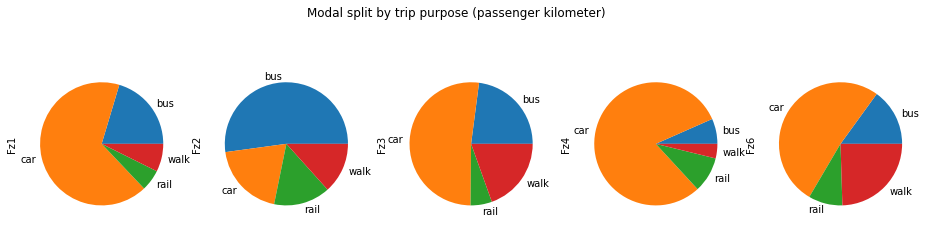

In [133]:
# Modal split by pkm
df.set_index(['mode', 'segment'], append=True)['pkm'].unstack().groupby(level=1).sum().plot.pie(
    subplots=True, figsize=(16, 4), legend=False, title='Modal split by trip purpose (passenger kilometer)')

In [134]:
# Vehicle kilometer for cars
df['vkm'] = [pkm/car_occ_dict[(u,p)] if m=='car' else 0 for u,m,p,pkm in zip(
    df['urb'], df['mode'], df['segment'], df['pkm'])]

In [135]:
# Cycling and walking is not counted to vkm
# PT km depend on the schedules
df['vkm'] = df['vkm'].astype(int)

In [136]:
# Create an aggregated version (NUTS2-level and no segments)
df['NUTS1'] = df.index.str[:3]
df_agg = df.groupby(['NUTS1', 'mode']).agg(
    {'volumes': 'sum', 'length': 'mean', 'time': 'mean',
     'price': 'mean', 'pkm': 'sum', 'vkm': 'sum'})

In [141]:
# Save an excel
with pd.ExcelWriter(output_path + 'inner_zone.xlsx') as writer:
    df.to_excel(writer, sheet_name='inner_zone')
    df_agg.to_excel(writer, sheet_name='agg')

In [142]:
# Save disaggregated pkm as CSV
df[['pkm', 'mode', 'segment']].to_csv(output_path + 'inner_zone_pkm.csv')